In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import heapq
import math
from io import StringIO

# ==========================================
# 1. ĐỌC DỮ LIỆU & TẠO MẠNG LƯỚI (MỚI)
# ==========================================

# Nội dung file của bạn (Giả lập việc đọc file)
file_content = """IdStart	IdEnd	Length
0	19	50.0000005
0	4	50.7202641
1	20	23.46118049
2	1	26.53881951
3	20	33.7851326
4	7	49.29230504
5	6	39.75493882
6	7	49.99788053
7	8	48.07455604
7	23	50.01365041
8	22	51.92921607
9	10	25.400051
10	24	19.10401294
11	12	22.86218046
12	13	28.99646058
13	14	44.45009089
14	15	26.54105604
15	18	100.0073205
16	9	109.008551
17	11	77.15021203
18	2	200.0326795
19	21	50
19	5	60.24506118
20	0	49.99999951
21	16	46.48738506
22	18	99.99174111
23	3	66.2148674
24	22	100.0082589
24	17	100
"""

# B1: Đọc vào DataFrame (Dùng sep='\t' hoặc delim_whitespace=True tùy file gốc)
df = pd.read_csv(StringIO(file_content), sep='\t') 
# Nếu đọc file thật: df = pd.read_csv('ten_file.txt', sep='\t')

print("--- MẪU DỮ LIỆU ĐẦU VÀO ---")
print(df.head())

# B2: Tạo đồ thị NetworkX từ dữ liệu
G = nx.from_pandas_edgelist(df, source='IdStart', target='IdEnd', edge_attr='Length')

# B3: Chuẩn hóa tên trọng số thành 'weight' (để thuật toán bên dưới hiểu)
for u, v in G.edges():
    G[u][v]['weight'] = G[u][v]['Length']

# B4: Tạo tọa độ giả để vẽ hình (Vì file không có x, y)
# spring_layout giúp các node liên kết kéo lại gần nhau, node rời rạc đẩy ra xa
pos = nx.spring_layout(G, seed=42) 

# B5: Tạo dữ liệu điểm sự kiện (Data Points)
# (Giả sử ta lấy ngẫu nhiên 15 node trong đồ thị làm sự kiện cần phân cụm)
all_nodes_in_graph = list(G.nodes())
data_nodes = random.sample(all_nodes_in_graph, k=min(15, len(all_nodes_in_graph)))

print(f"\nĐã tạo đồ thị: {G.number_of_nodes()} nút, {G.number_of_edges()} cạnh.")
print(f"Số điểm dữ liệu cần phân cụm: {len(data_nodes)}")
print(f"Các điểm dữ liệu mẫu: {data_nodes}")

--- MẪU DỮ LIỆU ĐẦU VÀO ---
   IdStart  IdEnd     Length
0        0     19  50.000000
1        0      4  50.720264
2        1     20  23.461180
3        2      1  26.538820
4        3     20  33.785133

Đã tạo đồ thị: 25 nút, 29 cạnh.
Số điểm dữ liệu cần phân cụm: 15
Các điểm dữ liệu mẫu: [9, 1, 17, 13, 5, 24, 15, 14, 10, 16, 21, 18, 6, 3, 2]


In [2]:
# ==========================================
# 2. THUẬT TOÁN NS-DBSCAN (GIỮ NGUYÊN BẢN GỐC - WANG 2019)
# ==========================================

# --- THUẬT TOÁN 1: LSPD ---
def algorithm_1_LSPD(G, cp, eps, data_set_lookup):
    distances = {cp: 0}
    queue = [(0, cp)]
    n_eps = [] 

    while queue:
        cdcv_p, p = heapq.heappop(queue)
        
        if cdcv_p > eps:
            continue

        if p in data_set_lookup:
            n_eps.append(p)
        
        for q in G.neighbors(p):
            w_pq = G[p][q]['weight']
            new_dist = cdcv_p + w_pq
            
            if new_dist <= eps:
                if new_dist < distances.get(q, float('inf')):
                    distances[q] = new_dist
                    heapq.heappush(queue, (new_dist, q))
    return n_eps

# --- THUẬT TOÁN 2: DENSITY ORDERING ---
def algorithm_2_density_ordering(G, data_points, eps):
    data_set_lookup = set(data_points)
    density_ordering_table = [] 
    in_table_set = set()
    
    neighbors_cache = {} 
    density_cache = {}

    def get_density_info(p):
        if p not in neighbors_cache:
            nbrs = algorithm_1_LSPD(G, p, eps, data_set_lookup)
            neighbors_cache[p] = nbrs
            density_cache[p] = len(nbrs)
        return density_cache[p], neighbors_cache[p]

    for p in data_points:
        if p not in in_table_set:
            p_density, _ = get_density_info(p)
            Q = [(-p_density, p)] 
            in_Q_set = {p}
            
            while Q:
                neg_dens, q = heapq.heappop(Q)
                
                if q not in in_table_set:
                    density_ordering_table.append(q)
                    in_table_set.add(q)
                
                _, q_neighbors = get_density_info(q)
                
                for neighbor in q_neighbors:
                    nb_density, _ = get_density_info(neighbor)
                    if (neighbor not in in_table_set) and (neighbor not in in_Q_set):
                        heapq.heappush(Q, (-nb_density, neighbor))
                        in_Q_set.add(neighbor)
                        
    return density_ordering_table, neighbors_cache

# --- THUẬT TOÁN 3: FORMING CLUSTERS ---
def algorithm_3_forming_clusters(density_ordering_table, neighbors_cache, min_pts):
    labels = {} 
    cluster_id = 0
    NOISE = -1
    
    for p in density_ordering_table:
        if p in labels:
            continue
            
        p_neighbors = neighbors_cache[p]
        p_density = len(p_neighbors)
        
        if p_density < min_pts:
            labels[p] = NOISE
        else:
            cluster_id += 1
            labels[p] = cluster_id
            
            seeds = [p]
            i = 0
            while i < len(seeds):
                q = seeds[i]
                q_neighbors = neighbors_cache[q]
                q_density = len(q_neighbors)
                
                if q_density >= min_pts:
                    for s in q_neighbors:
                        if s not in labels: 
                            labels[s] = cluster_id
                            seeds.append(s) 
                        elif labels[s] == NOISE: 
                            labels[s] = cluster_id 
                            
                i += 1
    return labels

def run_ns_dbscan_paper_version(G, data_points, eps, min_pts):
    print("\n--- BẮT ĐẦU NS-DBSCAN (PAPER VERSION) ---")
    print("Step 1: Generating Density Ordering...")
    table, cache = algorithm_2_density_ordering(G, data_points, eps)
    print(f"   -> Đã sắp xếp {len(table)} điểm.")
    
    print("Step 2: Forming Clusters...")
    labels = algorithm_3_forming_clusters(table, cache, min_pts)
    return labels


--- BẮT ĐẦU NS-DBSCAN (PAPER VERSION) ---
Step 1: Generating Density Ordering...
   -> Đã sắp xếp 15 điểm.
Step 2: Forming Clusters...

KẾT QUẢ PHÂN CỤM:
- Tổng số điểm: 15
- Điểm thuộc cụm: 13
- Điểm nhiễu (NOISE): 2
- Chi tiết nhãn: {9: 1, 10: 1, 24: 1, 1: 2, 2: 2, 3: 2, 17: -1, 13: 3, 14: 3, 15: 3, 5: 4, 6: 4, 16: 5, 21: 5, 18: -1}


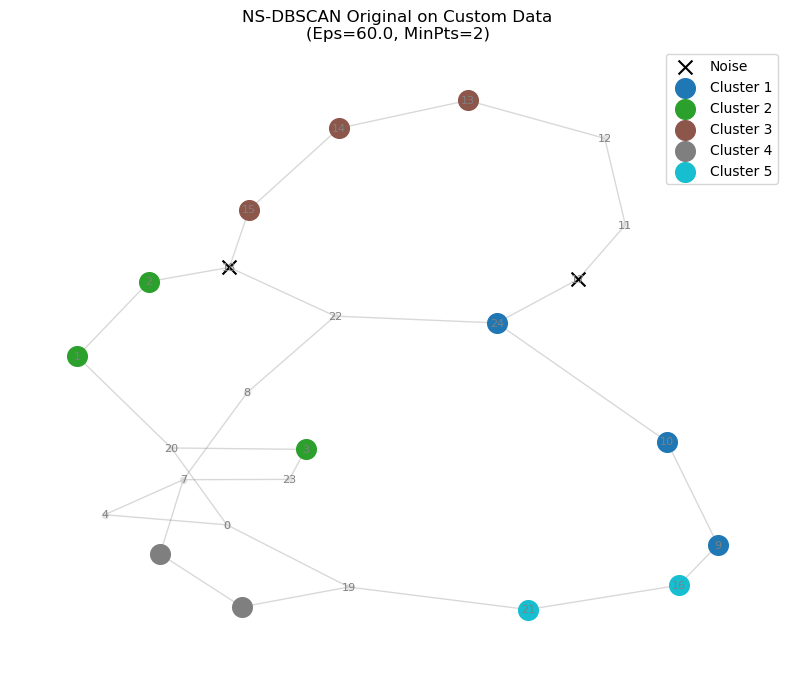

In [3]:
# ==========================================
# 3. CHẠY VÀ HIỂN THỊ
# ==========================================

# Cấu hình tham số (Dựa trên độ dài cạnh trong file của bạn)
# Cạnh trong file có độ dài khoảng 20-100, nên Eps phải lớn tương ứng
EPS = 60.0    # Ví dụ: Tìm hàng xóm trong bán kính 60 đơn vị
MIN_PTS = 2   # Mật độ tối thiểu

labels_paper = run_ns_dbscan_paper_version(G, data_nodes, EPS, MIN_PTS)

# Thống kê
n_noise = list(labels_paper.values()).count(-1)
n_clustered = len(labels_paper) - n_noise
print(f"\nKẾT QUẢ PHÂN CỤM:")
print(f"- Tổng số điểm: {len(data_nodes)}")
print(f"- Điểm thuộc cụm: {n_clustered}")
print(f"- Điểm nhiễu (NOISE): {n_noise}")
print(f"- Chi tiết nhãn: {labels_paper}")

# Vẽ đồ thị
plt.figure(figsize=(10, 8))

# Vẽ toàn bộ mạng lưới (màu xám nhạt)
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='lightgray', alpha=0.5)
# Vẽ nhãn cho các node để dễ đối chiếu với file
nx.draw_networkx_labels(G, pos, font_size=8, font_color='gray')

# Tách dữ liệu vẽ
clusters = {}
noise_nodes = []
for p, label in labels_paper.items():
    if label == -1:
        noise_nodes.append(p)
    else:
        if label not in clusters: clusters[label] = []
        clusters[label].append(p)

# Vẽ Noise
if noise_nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=noise_nodes, node_color='black', node_size=100, node_shape='x', label='Noise')

# Vẽ Cụm
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))
for i, c_id in enumerate(clusters.keys()):
    nx.draw_networkx_nodes(G, pos, nodelist=clusters[c_id], node_color=[colors[i]], node_size=200, label=f'Cluster {c_id}')

plt.title(f"NS-DBSCAN Original on Custom Data\n(Eps={EPS}, MinPts={MIN_PTS})")
plt.legend()
plt.axis('off')
plt.show()